### Iron Modelers

### Team members: Harika Rallapalli, Vedant Thakkar, and Kenneth Zhang

### CSC577

## **Imports**

In [71]:
import numpy as np
import pandas as pd
import re
import nltk

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, ndcg_score
)
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

!pip install nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# LightFM imports
!pip install lightfm --upgrade
from lightfm.data import Dataset
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Multiply, Concatenate, Dense, Flatten
from tensorflow.keras.models import Model

## **Bayesian Personalized Ranking**

Data collection and preprocessing

In [72]:
movieData = pd.read_csv('/content/drive/MyDrive/College/Masters/S2/CSC 577 Recommender Systems/Final Project/cleanedmovies.csv')
copy_movieData = movieData.copy()

In [73]:
# Created a copy of user id, movie id, and rating dataframe
df = movieData[['userId', 'movieId', 'rating', 'original_title', 'popularity', 'genres']].copy()

# Implicit rating of copied dataframe of setting values to 1 if rating is above 3.5 else 0
df['implicit_rating'] = df['rating'].apply(lambda x: 1 if x >= 3.5 else 0)

userId_to_index = {user_id: index for index, user_id in enumerate(df['userId'].unique())}
movieId_to_index = {movie_id: index for index, movie_id in enumerate(df['movieId'].unique())}

In [74]:
scaler = StandardScaler()
df['popularity'] = scaler.fit_transform(df[['popularity']])

item_features = []
for _, row in df.iterrows():
    item_features.append((row['movieId'], [f'popularity:{row["popularity"]:.4f}']))

In [75]:
# Interactions matrix without feature items
dataset = Dataset()
dataset.fit(users=df['userId'].unique(),
            items=df['movieId'].unique())

(interactions, weights) = dataset.build_interactions(
    [(row['userId'], row['movieId'], row['implicit_rating']) for _, row in df.iterrows()]
)

In [76]:
# Using dataset library to fit all unique user ids and movie ids with feature items
dataset2 = Dataset()
dataset2.fit(users=df['userId'].unique(),
            items=df['movieId'].unique(),
            item_features=[f'popularity:{x:.4f}' for x in df['popularity'].unique()])

# Create a interaction matrix in order to input into learning model
(interactions2, weights2) = dataset2.build_interactions(
    [(row['userId'], row['movieId'], row['implicit_rating']) for _, row in df.iterrows()]
)

# Popularity feature matrix
feature_matrix = dataset2.build_item_features(item_features, normalize=False)

Hyperparameter Tuning

In [77]:
'''
# There is a hard coded result below this with the results because it took about 3 hours to run

# Interaction matrix separated into 80-20
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

# Tuning parameters
components = [32, 64, 96, 128]
learning_rates = [0.001, 0.005, 0.01]
epochs = [10, 30, 50, 70, 90]
item_alpha = [0.001, 0.005, 0.01]
user_alpha = [0.001, 0.005, 0.01]

best_score = 0
best_params = {}

# Iterate through tuning parameters to find best score
for comp in components:
    for lr in learning_rates:
      for ep in epochs:
        for ia in item_alpha:
          for ua in user_alpha:
            # LightFM model use bpr as a loss factor
            model = LightFM(loss='bpr', no_components=comp, k=10, learning_rate=lr, item_alpha=ia, user_alpha=ua,random_state=42)
            model.fit(train, epochs=ep, num_threads=4)

            # Precision, Recall, and AUC score calculated for test data
            precision = precision_at_k(model, test, k=10, num_threads=4).mean()
            recall = recall_at_k(model, test, k=10).mean()
            auc = auc_score(model, test).mean()

            # Collects best score
            if auc > best_score:
                best_score = auc
                best_params = {
                    'no_components': comp,
                    'learning_rate': lr,
                    'epochs': ep,
                    'item_alpha': ia,
                    'user_alpha': ua,
                    'precision': precision,
                    'recall': recall,
                    'auc': auc
                }

            print(f"Components: {comp}, Learning Rate: {lr}, Epoch: {ep}, Item Alpha: {ia}, User Alpha: {ua}")
            print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}")
            print("---")
'''

'\n# There is a hard coded result below this with the results because it took about 3 hours to run\n\n# Interaction matrix separated into 80-20\ntrain, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)\n\n# Tuning parameters\ncomponents = [32, 64, 96, 128]\nlearning_rates = [0.001, 0.005, 0.01]\nepochs = [10, 30, 50, 70, 90]\nitem_alpha = [0.001, 0.005, 0.01]\nuser_alpha = [0.001, 0.005, 0.01]\n\nbest_score = 0\nbest_params = {}\n\n# Iterate through tuning parameters to find best score\nfor comp in components:\n    for lr in learning_rates:\n      for ep in epochs:\n        for ia in item_alpha:\n          for ua in user_alpha:\n            # LightFM model use bpr as a loss factor\n            model = LightFM(loss=\'bpr\', no_components=comp, k=10, learning_rate=lr, item_alpha=ia, user_alpha=ua,random_state=42)\n            model.fit(train, epochs=ep, num_threads=4)\n\n            # Precision, Recall, and AUC score calculated for test data\n            

Model Fit with best parameters

In [78]:
# Hard coded results from previous tuning
train, test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)

best_score = 0.5923885107040405
best_params = {
  'no_components': 96,
  'learning_rate': 0.001,
  'epochs': 90,
  'item_alpha': 0.005,
  'user_alpha': 0.001,
  'precision': 0.1527132,
  'recall': 0.06149650391280108,
  'auc': 0.5923885107040405
  }

In [79]:
print(f'Best AUC for Test Set: {best_score}')
print(f'Best Params for Test Set: {best_params}')

Best AUC for Test Set: 0.5923885107040405
Best Params for Test Set: {'no_components': 96, 'learning_rate': 0.001, 'epochs': 90, 'item_alpha': 0.005, 'user_alpha': 0.001, 'precision': 0.1527132, 'recall': 0.06149650391280108, 'auc': 0.5923885107040405}


In [80]:
# Final model with the best tuning results without feature maxtis
bpr_model = LightFM(loss='bpr', no_components=best_params['no_components'], learning_rate=best_params['learning_rate'], item_alpha=best_params['user_alpha'], user_alpha=best_params['item_alpha'],random_state=42)
bpr_model.fit(interactions, epochs=best_params['epochs'], num_threads=4)

In [81]:
# Model with feature matrix
bpr_model2 = LightFM(loss='bpr', no_components=best_params['no_components'], learning_rate=best_params['learning_rate'], item_alpha=best_params['user_alpha'], user_alpha=best_params['item_alpha'],random_state=42)
bpr_model2.fit(interactions2, item_features=feature_matrix, epochs=best_params['epochs'], num_threads=4)

Train Evaluation

In [82]:
# Precision and recall for the training
train_precision = precision_at_k(bpr_model, train, k=10).mean()
train_recall = recall_at_k(bpr_model, train, k=10).mean()

# With item features
train_precision2 = precision_at_k(bpr_model2, train, item_features=feature_matrix, k=10).mean()
train_recall2 = recall_at_k(bpr_model2, train, item_features=feature_matrix, k=10,).mean()

Train Precision: 0.7287
Train Recall: 0.0723
Train Precision with Feature: 0.7196
Train Recall with Feature: 0.0714


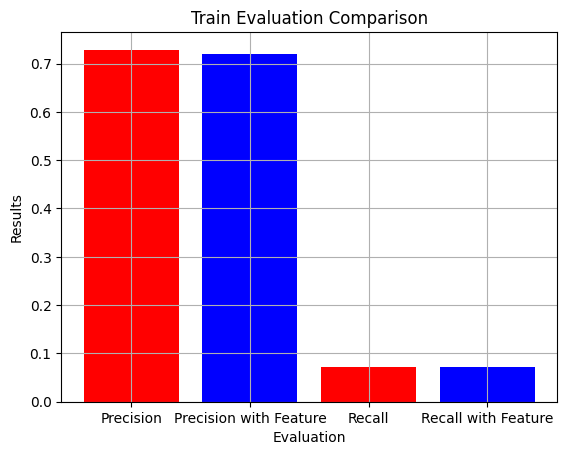

In [83]:
train_result = [train_precision, train_precision2, train_recall, train_recall2]
train_scores = ['Precision', 'Precision with Feature', 'Recall', 'Recall with Feature']

plt.bar(train_scores, train_result, color=['red', 'blue', 'red', 'blue'])
plt.xlabel('Evaluation')
plt.ylabel('Results')
plt.title('Train Evaluation Comparison')
plt.grid(True)
print(f'Train Precision: {train_precision:.4f}')
print(f'Train Recall: {train_recall:.4f}')
print(f'Train Precision with Feature: {train_precision2:.4f}')
print(f'Train Recall with Feature: {train_recall2:.4f}')

Test Evaluation

In [84]:
# Precision and recall for the test scores
test_precision = precision_at_k(bpr_model, test, k=10).mean()
test_recall = recall_at_k(bpr_model, test, k=10,).mean()

# With feature matrix
test_precision2 = precision_at_k(bpr_model2, test, item_features=feature_matrix, k=10).mean()
test_recall2 = recall_at_k(bpr_model2, test, item_features=feature_matrix, k=10,).mean()

Test Precision: 0.1837
Test Recall: 0.0726
Test Precision with Feature: 0.1823
Test Recall with Feature: 0.0716


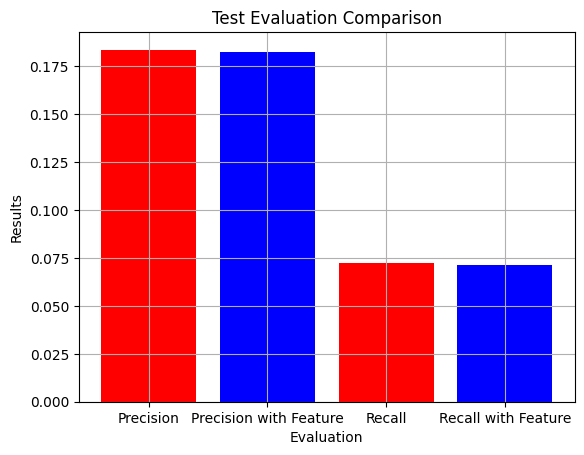

In [85]:
test_result = [test_precision, test_precision2, test_recall, test_recall2]
test_scores = ['Precision', 'Precision with Feature', 'Recall', 'Recall with Feature']

plt.bar(test_scores, test_result, color=['red', 'blue','red', 'blue'])
plt.xlabel('Evaluation')
plt.ylabel('Results')
plt.title('Test Evaluation Comparison')
plt.grid(True)

print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test Precision with Feature: {test_precision2:.4f}')
print(f'Test Recall with Feature: {test_recall2:.4f}')

Model Evaluation

In [86]:
# Used to find the predictions and true predictions for NDCG
# Without feature matrix
num_users, num_items = interactions.shape
user_ids = np.repeat(np.arange(num_users), num_items)
item_ids = np.tile(np.arange(num_items), num_users)

predict = bpr_model.predict(user_ids, item_ids)
predict_array = np.array(predict).reshape(num_users, num_items)

actual = interactions.toarray()

In [87]:
# Final calculated scores without feature matrix
ndcg = ndcg_score(actual, predict_array)
final_precision = precision_at_k(bpr_model, interactions, k=10).mean()
final_recall = recall_at_k(bpr_model, interactions, k=10).mean()

print(f"Precision: {final_precision:.4f}, Recall: {final_recall:.4f}, NDCG: {ndcg:.4f}")

Precision: 0.9124, Recall: 0.0724, NDCG: 0.9440


In [88]:
# Used to find the predictions and true predictions for NDCG
# WITH feature matrix
num_users2, num_items2 = interactions2.shape
user_ids2 = np.repeat(np.arange(num_users2), num_items2)
item_ids2 = np.tile(np.arange(num_items2), num_users2)

predict2 = bpr_model2.predict(user_ids2, item_ids2)
predict_array2 = np.array(predict2).reshape(num_users2, num_items2)

actual2 = interactions2.toarray()

In [89]:
ndcg2 = ndcg_score(actual2, predict_array2)
final_precision2 = precision_at_k(bpr_model2, interactions2, item_features=feature_matrix, k=10).mean()
final_recall2 = recall_at_k(bpr_model2, interactions2, item_features=feature_matrix, k=10).mean()

print(f"Precision: {final_precision2:.4f}, Recall: {final_recall2:.4f}, NDCG: {ndcg2:.4f}")

Precision: 0.9019, Recall: 0.0715, NDCG: 0.8958


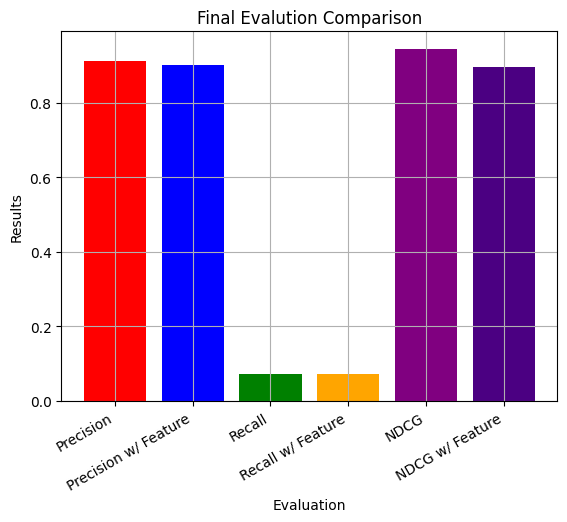

Precision: 0.9124, Precision with Feature: 0.9019 Recall: 0.0724, Recall with Feature: 0.0715, NDCG: 0.9440, NDCG with Feature: 0.8958


In [90]:
# Graph of final scores
results = [final_precision, final_precision2, final_recall, final_recall2, ndcg, ndcg2]
scores = ['Precision', 'Precision w/ Feature', 'Recall', 'Recall w/ Feature', 'NDCG', 'NDCG w/ Feature']

plt.bar(scores, results, color=['red', 'blue', 'green', 'orange', 'purple', 'indigo'])
plt.xlabel('Evaluation')
plt.ylabel('Results')
plt.title('Final Evalution Comparison')
plt.xticks(rotation=30, ha="right")
plt.grid(True)
plt.show()

print(f"Precision: {final_precision:.4f}, Precision with Feature: {final_precision2:.4f} Recall: {final_recall:.4f}, Recall with Feature: {final_recall2:.4f}, NDCG: {ndcg:.4f}, NDCG with Feature: {ndcg2:.4f}")

MAE: 0.6123, MAE with Feature: 0.6339, RMSE: 0.6090, RMSE with Feature: 0.6311


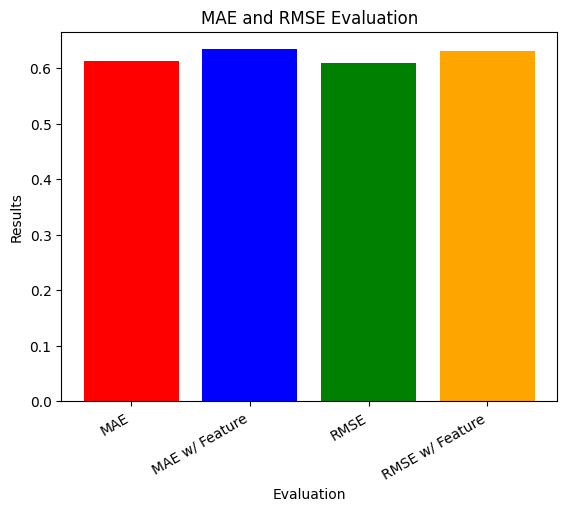

In [91]:
# MAE and RMSE
mae = mean_absolute_error(actual, predict_array)
rmse = mean_squared_error(actual, predict_array)
mae2 = mean_absolute_error(actual2, predict_array2)
rmse2 = mean_squared_error(actual2, predict_array2)

results2 = [mae, mae2, rmse, rmse2]
scores2 = ['MAE', 'MAE w/ Feature', 'RMSE', 'RMSE w/ Feature']

plt.bar(scores2, results2, color=['red', 'blue', 'green', 'orange'])
plt.xlabel('Evaluation')
plt.ylabel('Results')
plt.title('MAE and RMSE Evaluation')
plt.xticks(rotation=30, ha="right")

print(f"MAE: {mae:.4f}, MAE with Feature: {mae2:.4f}, RMSE: {rmse:.4f}, RMSE with Feature: {rmse2:.4f}")

In [92]:
bpr_metrics = {
    'Precision': final_precision,
    'Precision with Feature': final_precision2,
    'Recall': final_recall,
    'Recall with Feature': final_recall2,
    'NDCG': ndcg,
    'NDCG with Feature': ndcg2,
    'MAE': mae,
    'MAE with Feature': mae2,
    'RMSE': rmse,
    'RMSE with Feature': rmse2,
}

Example Use Case

In [93]:
# Converts user to index
userId_index = {user_id: idx for idx, user_id in enumerate(df['userId'].unique())}
movieId_index = {movie_id: idx for idx, movie_id in enumerate(df['movieId'].unique())}

list_movies_unique = df['movieId'].unique().tolist()
list_movies = [m for m in list_movies_unique if m in movieId_to_index]

# Specified user recommendation to look for
user = 150
user_index = userId_index[user]

# Convert movie IDs to indices
item_indices = [movieId_index[movie] for movie in list_movies if movie in movieId_index]

In [94]:
# Predict scores without features
predicted = bpr_model.predict(user_index, item_indices)

# Sorts top 10 movies indexs
top_movies = np.argsort(-predicted)[:10]

# Convert back to movie IDs
recommended_movie_ids = [list(movieId_index.keys())[i] for i in top_movies]

recommended_movies = [df[df['movieId'] == movie_id]['original_title'].values[0] for movie_id in recommended_movie_ids if movie_id in df['movieId'].values]
top_movie_scores = predicted[top_movies]

print(f"Recommended movies without Feature Item for user {user}:")
for i in range(len(recommended_movies)):
    print(f'{i+1}. "{recommended_movies[i]}" with Score: {top_movie_scores[i]:.4f}')
    print()

Recommended movies without Feature Item for user 150:
1. "The 39 Steps" with Score: 0.0239

2. "Rope" with Score: 0.0230

3. "Bridge to Terabithia" with Score: 0.0230

4. "Terminator 3: Rise of the Machines" with Score: 0.0229

5. "A Nightmare on Elm Street" with Score: 0.0211

6. "Young and Innocent" with Score: 0.0208

7. "The Million Dollar Hotel" with Score: 0.0206

8. "The Conversation" with Score: 0.0201

9. "Men in Black II" with Score: 0.0178

10. "Light of Day" with Score: 0.0146



In [95]:
# Predict scores WITH features
predicted2 = bpr_model2.predict(user_index, item_indices)

# Sorts top 10 movies indexs
top_movies2 = np.argsort(-predicted2)[:10]

# Convert back to movie IDs
recommended_movie_ids2 = [list(movieId_index.keys())[i] for i in top_movies2]

recommended_movies2 = [df[df['movieId'] == movie_id]['original_title'].values[0] for movie_id in recommended_movie_ids2 if movie_id in df['movieId'].values]
top_movie_scores2 = predicted2[top_movies2]

print(f"Recommended movies with Feature Item for user {user}:")
for i in range(len(recommended_movies2)):
    print(f'{i+1}. "{recommended_movies2[i]}" with Score: {top_movie_scores2[i]:.4f}')
    print()

Recommended movies with Feature Item for user 150:
1. "Terminator 3: Rise of the Machines" with Score: 0.0958

2. "Shriek If You Know What I Did Last Friday the Thirteenth" with Score: 0.0907

3. "License to Wed" with Score: 0.0824

4. "My Name Is Bruce" with Score: 0.0820

5. "48 Hrs." with Score: 0.0819

6. "Wag the Dog" with Score: 0.0791

7. "Notes on a Scandal" with Score: 0.0745

8. "The Thirteenth Floor" with Score: 0.0674

9. "Live and Let Die" with Score: 0.0668

10. "Street Kings" with Score: 0.0665



Example of Bad outcomes

In [96]:
# Predict scores without features
predicted = bpr_model.predict(user_index, item_indices)

# Sorts top 10 movies indexs
top_movies = np.argsort(predicted)[:10]

# Convert back to movie IDs
recommended_movie_ids = [list(movieId_index.keys())[i] for i in top_movies]

recommended_movies = [df[df['movieId'] == movie_id]['original_title'].values[0] for movie_id in recommended_movie_ids if movie_id in df['movieId'].values]
top_movie_scores = predicted[top_movies]

print(f"Bad recommended movies without Feature Item for user {user}:")
for i in range(len(recommended_movies)):
    print(f'{i+1}. "{recommended_movies[i]}" with Score: {top_movie_scores[i]:.4f}')
    print()

Bad recommended movies without Feature Item for user 150:
1. "Monty Python and the Holy Grail" with Score: -0.0176

2. "Cat on a Hot Tin Roof" with Score: -0.0150

3. "In Time" with Score: -0.0148

4. "Longitude" with Score: -0.0146

5. "Eyes Wide Shut" with Score: -0.0145

6. "Shuang ma lian huan" with Score: -0.0144

7. "The Good Thief" with Score: -0.0137

8. "The Dark" with Score: -0.0135

9. "The Sixth Sense" with Score: -0.0133

10. "Indestructible Man" with Score: -0.0133



In [97]:
# Predict scores WITH features
predicted2 = bpr_model2.predict(user_index, item_indices)

# Sorts top 10 movies indexs
top_movies2 = np.argsort(predicted2)[:10]

# Convert back to movie IDs
recommended_movie_ids2 = [list(movieId_index.keys())[i] for i in top_movies2]

recommended_movies2 = [df[df['movieId'] == movie_id]['original_title'].values[0] for movie_id in recommended_movie_ids2 if movie_id in df['movieId'].values]
top_movie_scores2 = predicted2[top_movies2]

print(f"Bad movies with Feature Item for user {user}:")
for i in range(len(recommended_movies2)):
    print(f'{i+1}. "{recommended_movies2[i]}" with Score: {top_movie_scores2[i]:.4f}')
    print()

Bad movies with Feature Item for user 150:
1. "Jacob's Ladder" with Score: -0.1026

2. "Once Were Warriors" with Score: -0.1011

3. "Rocky Balboa" with Score: -0.0993

4. "Point Break" with Score: -0.0993

5. "The Talented Mr. Ripley" with Score: -0.0979

6. "Big Fish" with Score: -0.0977

7. "Men in Black II" with Score: -0.0966

8. "The Hours" with Score: -0.0953

9. "Mr. Holland's Opus" with Score: -0.0933

10. "To Kill a Mockingbird" with Score: -0.0927



## **Logistic Regression**

Preprocessing

In [98]:
movieData = copy_movieData
movieData['content'] = movieData['genres'] + ' ' + movieData['overview']
movieData = movieData.sample(n=10000, random_state=42)

Tuning and Training

In [99]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I)

    # Convert to lowercase
    text = text.lower()

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stop words and stem the remaining words
    cleaned_words = [stemmer.stem(word) for word in words if word not in stop_words]

    cleaned_text = ' '.join(cleaned_words)

    return cleaned_text

# Apply text cleaning to the 'content' column
movieData['cleaned_content'] = movieData['content'].apply(clean_text)

# TF-IDF for content-based features on the cleaned text
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(movieData['cleaned_content'])
print(f'TF-IDF matrix shape: {tfidf_matrix.shape}')

# Create the target variable 'liked' based on rating
movieData['liked'] = (movieData['rating'] >= 3.5).astype(int)

# Prepare features and target for the model
X = tfidf_matrix.toarray()
y = movieData['liked'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg']
}

log_reg = LogisticRegression(penalty='l2')

grid_search_lr = GridSearchCV(log_reg, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

best_log_reg = grid_search_lr.best_estimator_
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print(f"Best Logistic Regression Parameters: {best_params_lr}")
y_pred_train = best_log_reg.predict(X_train)
y_pred_test = best_log_reg.predict(X_test)

precision_lr = precision_score(y_test, y_pred_test)
recall_lr = recall_score(y_test, y_pred_test)
roc_auc_lr = roc_auc_score(y_test, y_pred_test)

print(f'Precision (Logistic Regression): {precision_lr:.4f}')
print(f'Recall (Logistic Regression): {recall_lr:.4f}')
print(f'ROC-AUC (Logistic Regression): {roc_auc_lr:.4f}')

# Hyperparameter tuning for PCA and Logistic Regression (after PCA)
best_pca = PCA(n_components=0.95)
X_train_pca = best_pca.fit_transform(X_train)
X_test_pca = best_pca.transform(X_test)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'newton-cg']
}

grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X_train_pca, y_train)

best_log_reg_pca = grid_search_lr.best_estimator_
best_params_lr = grid_search_lr.best_params_
best_score_lr = grid_search_lr.best_score_

print(f"Best Logistic Regression Parameters (after PCA): {best_params_lr}")

y_pred_train_pca = best_log_reg_pca.predict(X_train_pca)
y_pred_test_pca = best_log_reg_pca.predict(X_test_pca)
precision_lr_pca = precision_score(y_test, y_pred_test_pca)
recall_lr_pca = recall_score(y_test, y_pred_test_pca)
roc_auc_lr_pca = roc_auc_score(y_test, y_pred_test_pca)

print(f'Precision (after PCA): {precision_lr_pca:.4f}')
print(f'Recall (after PCA): {recall_lr_pca:.4f}')
print(f'ROC-AUC (after PCA): {roc_auc_lr_pca:.4f}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


TF-IDF matrix shape: (10000, 2890)
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression Parameters: {'C': 10, 'solver': 'liblinear'}
Precision (Logistic Regression): 0.6864
Recall (Logistic Regression): 0.8137
ROC-AUC (Logistic Regression): 0.6298
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression Parameters (after PCA): {'C': 1, 'solver': 'newton-cg'}
Precision (after PCA): 0.6713
Recall (after PCA): 0.8120
ROC-AUC (after PCA): 0.6096


Evaluation

In [100]:
# Function to compute RMSE, MAE, and NDCG for classification
def compute_classification_metrics(y_true, y_pred_proba, k=10):
    # Calculate RMSE based on predicted probabilities
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_proba))

    # Calculate MAE based on predicted probabilities
    mae = mean_absolute_error(y_true, y_pred_proba)

    # Compute NDCG (Normalized Discounted Cumulative Gain)
    # i am using the true values as relevance scores, and the predicted probabilities as predicted scores
    ndcg = ndcg_score([y_true], [y_pred_proba], k=k)

    return {
        'RMSE (Classification)': rmse,
        'MAE (Classification)': mae,
        'NDCG (Classification)': ndcg
    }

# Predict probabilities for class 1 (liked) using Logistic Regression without PCA
y_pred_test_proba = best_log_reg.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1 (liked)

# Compute RMSE, MAE, and NDCG for Logistic Regression without PCA
metrics_classification_lr = compute_classification_metrics(y_test, y_pred_test_proba)

# Predict probabilities for class 1 (liked) using Logistic Regression with PCA
y_pred_test_pca_proba = best_log_reg_pca.predict_proba(X_test_pca)[:, 1]  # Predicted probabilities for class 1 (liked) after PCA

# Compute RMSE, MAE, and NDCG for Logistic Regression with PCA
metrics_classification_lr_pca = compute_classification_metrics(y_test, y_pred_test_pca_proba)

# Print the evaluation metrics for Logistic Regression without PCA
print("Logistic Regression Metrics (without PCA):")
for metric, value in metrics_classification_lr.items():
    print(f"{metric}: {value:.4f}")

# Print the evaluation metrics for Logistic Regression with PCA
print("\nLogistic Regression Metrics (with PCA):")
for metric, value in metrics_classification_lr_pca.items():
    print(f"{metric}: {value:.4f}")


Logistic Regression Metrics (without PCA):
RMSE (Classification): 0.4626
MAE (Classification): 0.4120
NDCG (Classification): 0.7500

Logistic Regression Metrics (with PCA):
RMSE (Classification): 0.4659
MAE (Classification): 0.4256
NDCG (Classification): 0.7500


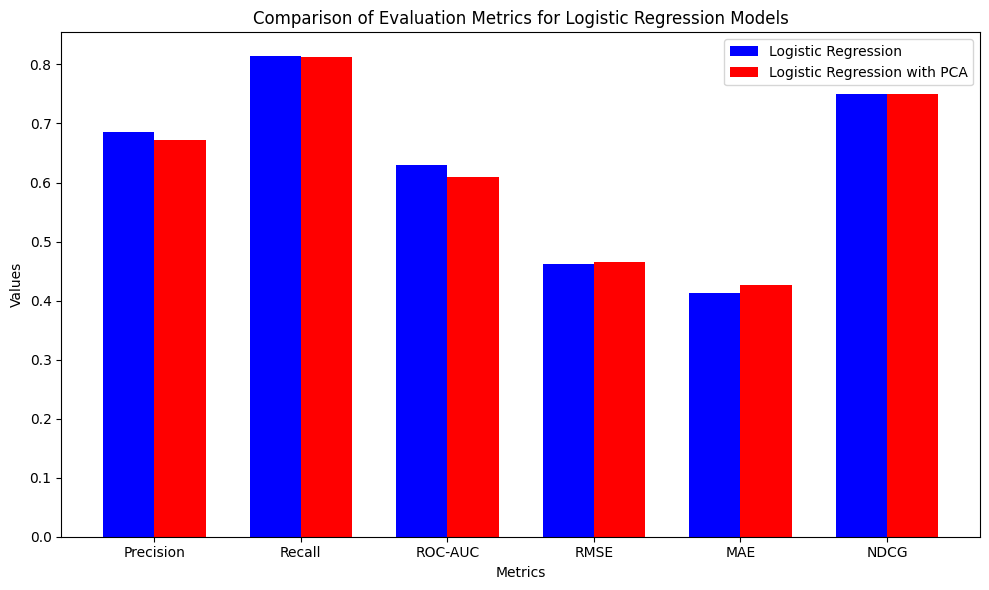

In [101]:
metrics_lr = {
    'Precision': precision_lr,
    'Recall': recall_lr,
    'ROC-AUC': roc_auc_lr,
    'RMSE': metrics_classification_lr['RMSE (Classification)'],
    'MAE': metrics_classification_lr['MAE (Classification)'],
    'NDCG': metrics_classification_lr['NDCG (Classification)']
}

metrics_lr_pca = {
    'Precision': precision_lr_pca,
    'Recall': recall_lr_pca,
    'ROC-AUC': roc_auc_lr_pca,
    'RMSE': metrics_classification_lr_pca['RMSE (Classification)'],
    'MAE': metrics_classification_lr_pca['MAE (Classification)'],
    'NDCG': metrics_classification_lr_pca['NDCG (Classification)']
}

# Creating the bar plot
labels = ['Precision', 'Recall', 'ROC-AUC', 'RMSE', 'MAE', 'NDCG']
log_reg_values = [metrics_lr['Precision'], metrics_lr['Recall'], metrics_lr['ROC-AUC'], metrics_lr['RMSE'], metrics_lr['MAE'], metrics_lr['NDCG']]
log_reg_pca_values = [metrics_lr_pca['Precision'], metrics_lr_pca['Recall'], metrics_lr_pca['ROC-AUC'], metrics_lr_pca['RMSE'], metrics_lr_pca['MAE'], metrics_lr_pca['NDCG']]

x = range(len(labels))

# Plotting the comparison
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
ax.bar(x, log_reg_values, bar_width, label='Logistic Regression', color='b')
ax.bar([p + bar_width for p in x], log_reg_pca_values, bar_width, label='Logistic Regression with PCA', color='r')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Evaluation Metrics for Logistic Regression Models')
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


Example Use Case

In [102]:
#Recommendation function for printing top recommendations to a user using logistic regression with PCA
def recommend_items(user_id, model, ratings_df, movieData, tfidf, top_n=10):

    user_ratings = ratings_df[ratings_df['userId'] == user_id]

    # Get the content-based features for all movies
    all_dramas = movieData[['movieId', 'content', 'original_title']]

    # Predict the likelihood of the user liking all dramas they haven't rated yet
    unseen_dramas = all_dramas[~all_dramas['movieId'].isin(user_ratings['movieId'])]

    # Ensuring no duplicates in the unseen dramas
    unseen_dramas = unseen_dramas.drop_duplicates(subset=['movieId'])

    # Transform the content into TF-IDF features
    unseen_dramas_tfidf = tfidf.transform(unseen_dramas['content'])

    # Ensuring the unseen data has the same number of features as the training data
    if unseen_dramas_tfidf.shape[1] != X.shape[1]:
        raise ValueError(f"Unseen data has a different number of features: {unseen_dramas_tfidf.shape[1]} != {X.shape[1]}")

    # Predict the probability of liking each unseen drama using raw TF-IDF features
    predictions = model.predict_proba(unseen_dramas_tfidf)[:, 1]

    top_indices = predictions.argsort()[-top_n:][::-1]

    # Get unique movies for recommendations
    recommended_dramas = unseen_dramas.iloc[top_indices].drop_duplicates(subset=['movieId'])

    # Get the movie names and their predicted ratings corresponding to the recommended IDs
    recommended_movie_names = recommended_dramas['original_title'].values
    predicted_ratings = predictions[top_indices]  # These are the predicted ratings for each recommendation

    return recommended_movie_names, predicted_ratings

ratings_df = movieData[['userId', 'movieId', 'rating']]
recommended_items, relevance_scores = recommend_items(user_id=41507, model=best_log_reg, ratings_df=ratings_df, movieData=movieData, tfidf=tfidf, top_n=10)

print("Top Recommended items for user 41507:")
for item, score in zip(recommended_items, relevance_scores):
    print(f"{item} | Predicted Rating: {score:.4f}")

def ndcg_at_k(relevance_scores, k=10):
    """
    Calculate NDCG@k
    relevance_scores: Predicted relevance scores (e.g., probability of liking)
    k: Top-k recommendations
    """
    dcg_k = np.sum((2 ** relevance_scores[:k] - 1) / np.log2(np.arange(2, k + 2)))

    ideal_relevance_scores = np.sort(relevance_scores)[::-1]
    idcg_k = np.sum((2 ** ideal_relevance_scores[:k] - 1) / np.log2(np.arange(2, k + 2)))

    return dcg_k / idcg_k if idcg_k > 0 else 0.0

# Calculate NDCG@10
ndcg_score = ndcg_at_k(relevance_scores, k=10)
print(f'NDCG@10 for this user: {ndcg_score:.4f}')

Top Recommended items for user 41507:
The Million Dollar Hotel | Predicted Rating: 0.9006
The Big Sleep | Predicted Rating: 0.8583
The Thomas Crown Affair | Predicted Rating: 0.8560
Terminator 3: Rise of the Machines | Predicted Rating: 0.8381
Sleepless in Seattle | Predicted Rating: 0.8252
K-19: The Widowmaker | Predicted Rating: 0.8143
Notes on a Scandal | Predicted Rating: 0.7924
Star 80 | Predicted Rating: 0.7873
The Sixth Sense | Predicted Rating: 0.7624
Murder She Said | Predicted Rating: 0.7554
NDCG@10 for this user: 1.0000


In [103]:
# Function to recommend movies based on Logistic Regression (without PCA)
def recommend_movies(user_id, model, ratings_df, movieData, tfidf, top_n=10):

    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()

    unseen_movies = movieData[~movieData['movieId'].isin(user_rated_movies)].copy()

    unseen_movies = unseen_movies.drop_duplicates(subset=['movieId'])

    # TF-IDF vectors
    unseen_movies_tfidf = tfidf.transform(unseen_movies['content'])

    # Predict the probability of the user liking each unseen movie
    predictions = model.predict_proba(unseen_movies_tfidf)[:, 1]

    unseen_movies['predicted_proba'] = predictions

    top_recommendations = unseen_movies.sort_values(by='predicted_proba', ascending=False).head(top_n)

    # Get movie names and their predicted probabilities
    recommended_movie_names = top_recommendations['original_title'].values
    predicted_scores = top_recommendations['predicted_proba'].values

    return recommended_movie_names, predicted_scores

ratings_df = movieData[['userId', 'movieId', 'rating']]
user_id = 41507

# Get top 10 recommendations
recommended_items, relevance_scores = recommend_movies(user_id, best_log_reg, ratings_df, movieData, tfidf, top_n=10)

print(f"\n Top Movie Recommendations for User {user_id}:")
for item, score in zip(recommended_items, relevance_scores):
    print(f" {item} | Predicted Rating: {score:.4f}")

def ndcg_at_k(relevance_scores, k=10):
    """
    Compute Normalized Discounted Cumulative Gain (NDCG) at rank K.
    """
    dcg_k = np.sum((2 ** relevance_scores[:k] - 1) / np.log2(np.arange(2, k + 2)))

    ideal_relevance_scores = np.sort(relevance_scores)[::-1]  # Ideal order (highest scores first)
    idcg_k = np.sum((2 ** ideal_relevance_scores[:k] - 1) / np.log2(np.arange(2, k + 2)))

    return dcg_k / idcg_k if idcg_k > 0 else 0.0

# Compute NDCG@10
ndcg_score = ndcg_at_k(relevance_scores, k=10)
print(f'\n NDCG@10 for User {user_id}: {ndcg_score:.4f}')



 Top Movie Recommendations for User 41507:
 The Million Dollar Hotel | Predicted Rating: 0.9006
 The Big Sleep | Predicted Rating: 0.8583
 The Thomas Crown Affair | Predicted Rating: 0.8560
 Terminator 3: Rise of the Machines | Predicted Rating: 0.8381
 Sleepless in Seattle | Predicted Rating: 0.8252
 K-19: The Widowmaker | Predicted Rating: 0.8143
 Notes on a Scandal | Predicted Rating: 0.7924
 Star 80 | Predicted Rating: 0.7873
 The Sixth Sense | Predicted Rating: 0.7624
 Murder She Said | Predicted Rating: 0.7554

 NDCG@10 for User 41507: 1.0000


In [104]:
# Function to perform bad recommendation of movies based on Logistic Regression (without PCA)
def recommend_movies(user_id, model, ratings_df, movieData, tfidf, top_n=10):
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()

    unseen_movies = movieData[~movieData['movieId'].isin(user_rated_movies)].copy()

    unseen_movies = unseen_movies.drop_duplicates(subset=['movieId'])

    # TF-IDF vectors
    unseen_movies_tfidf = tfidf.transform(unseen_movies['content'])

    # Predict the probability of the user liking each unseen movie
    predictions = model.predict_proba(unseen_movies_tfidf)[:, 1]

    unseen_movies['predicted_proba'] = predictions

    # Sort movies by predicted probability in ascending order (low to high)
    top_recommendations = unseen_movies.sort_values(by='predicted_proba', ascending=True).head(top_n)

    # Get movie names and their predicted probabilities
    recommended_movie_names = top_recommendations['original_title'].values
    predicted_scores = top_recommendations['predicted_proba'].values

    return recommended_movie_names, predicted_scores

ratings_df = movieData[['userId', 'movieId', 'rating']]
user_id = 37422

# Get top 10 recommendations (now ordered from low to high predicted rating)
recommended_items, relevance_scores = recommend_movies(user_id, best_log_reg, ratings_df, movieData, tfidf, top_n=10)

print(f"\nBad Movie Recommendations for User {user_id}:")
for item, score in zip(recommended_items, relevance_scores):
    print(f" {item} | Predicted Rating: {score:.4f}")


Bad Movie Recommendations for User 37422:
 Monty Python and the Holy Grail | Predicted Rating: 0.1328
 Star Trek V: The Final Frontier | Predicted Rating: 0.1791
 Klute | Predicted Rating: 0.2240
 Imagine Me & You | Predicted Rating: 0.2482
 Lost in Translation | Predicted Rating: 0.2662
 Lucky Number Slevin | Predicted Rating: 0.2677
 The Day After Tomorrow | Predicted Rating: 0.3124
 Whale Rider | Predicted Rating: 0.3126
 Short Circuit | Predicted Rating: 0.3243
 Back to the Future Part III | Predicted Rating: 0.3287


## **Neural Collaborative Filtering (NCF)**

Preprocessing

In [105]:
movieData = copy_movieData

# Map user and movie IDs to integers
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

movieData['userId'] = user_encoder.fit_transform(movieData['userId'])
movieData['movieId'] = movie_encoder.fit_transform(movieData['movieId'])

# Normalize ratings to [0, 1]
movieData['rating'] = movieData['rating'] / 5.0

# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(movieData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Extract user IDs, movie IDs, and ratings
train_users = train_data['userId'].values
train_movies = train_data['movieId'].values
train_ratings = train_data['rating'].values

val_users = val_data['userId'].values
val_movies = val_data['movieId'].values
val_ratings = val_data['rating'].values

test_users = test_data['userId'].values
test_movies = test_data['movieId'].values
test_ratings = test_data['rating'].values

NCF Model

In [106]:
def build_ncf(num_users, num_movies, embedding_size, mlp_layers):
    # Input layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    movie_input = Input(shape=(1,), dtype='int32', name='movie_input')

    # Embedding layers
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

    # Flatten embeddings
    user_embedding = Flatten()(user_embedding)
    movie_embedding = Flatten()(movie_embedding)

    # GMF path
    gmf = Multiply()([user_embedding, movie_embedding])

    # MLP path
    mlp_input = Concatenate()([user_embedding, movie_embedding])
    mlp_output = Dense(mlp_layers[0], activation='relu')(mlp_input)
    for layer_size in mlp_layers[1:]:
        mlp_output = Dense(layer_size, activation='relu')(mlp_output)

    # Concatenate GMF and MLP
    combined = Concatenate()([gmf, mlp_output])

    # Output layer
    output = Dense(1, activation='sigmoid', name='output')(combined)

    # Define the model
    model = Model(inputs=[user_input, movie_input], outputs=output)
    return model

num_users = movieData['userId'].nunique()
num_movies = movieData['movieId'].nunique()
embedding_size = 32
mlp_layers = [64, 32, 16]

model = build_ncf(num_users, num_movies, embedding_size, mlp_layers)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 32)          │         24,768 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 32)          │          6,784 │ movie_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 32)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 32)             │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 64)             │              0 │ flatten_8[0][0],       │
│ (Concatenate)             │                        │                │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │          4,160 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 32)             │          2,080 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 32)             │              0 │ flatten_8[0][0],       │
│                           │                        │                │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 16)             │            528 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 48)             │              0 │ multiply_4[0][0],      │
│ (Concatenate)             │                        │                │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             49 │ concatenate_9[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,369 (149.88 KB)

 Trainable params: 38,369 (149.88 KB)

 Non-trainable params: 0 (0.00 B)

Compiling the model

In [107]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

# Prepare TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((train_users, train_movies), train_ratings))
val_dataset = tf.data.Dataset.from_tensor_slices(((val_users, val_movies), val_ratings))

# Batch and shuffle the datasets
train_dataset = train_dataset.batch(64).shuffle(10000)
val_dataset = val_dataset.batch(64)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5979 - mae: 0.1500 - val_loss: 0.5809 - val_mae: 0.1291
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5741 - mae: 0.1263 - val_loss: 0.5785 - val_mae: 0.1267
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5714 - mae: 0.1237 - val_loss: 0.5764 - val_mae: 0.1258
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5703 - mae: 0.1216 - val_loss: 0.5763 - val_mae: 0.1238
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5678 - mae: 0.1190 - val_loss: 0.5753 - val_mae: 0.1241
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.5639 - mae: 0.1173 - val_loss: 0.5746 - val_mae: 0.1231
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.5630 - mae: 0.1141 - val_loss: 0.5743 - val_mae: 0.1223
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5613 - mae: 0.1124 - val_loss: 0.5746 - val_mae: 0.1225
Epoch 9/10
1125/1125 ━━━━━━━━━━━━━━━━━━━

In [108]:
# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((test_users, test_movies), test_ratings))
test_dataset = test_dataset.batch(64)

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5719 - mae: 0.1243
Test Loss: 0.5710552930831909, Test MAE: 0.1238349974155426


Hyper Parameter Tuning

In [109]:
pip install keras-tuner

In [110]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Multiply, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import keras_tuner as kt

def build_tunable_model(hp):
    # Tunable hyperparameters
    embedding_size = hp.Int('embedding_size', min_value=16, max_value=128, step=16)
    mlp_layers = hp.Int('mlp_layers', min_value=1, max_value=3)
    layer_size = hp.Int('layer_size', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Input layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    movie_input = Input(shape=(1,), dtype='int32', name='movie_input')

    # Embedding layers
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

    # Flatten embeddings
    user_embedding = Flatten()(user_embedding)
    movie_embedding = Flatten()(movie_embedding)

    # GMF path
    gmf = Multiply()([user_embedding, movie_embedding])

    # MLP path
    mlp_input = Concatenate()([user_embedding, movie_embedding])
    mlp_output = Dense(layer_size, activation='relu')(mlp_input)
    mlp_output = Dropout(dropout_rate)(mlp_output)
    for _ in range(mlp_layers - 1):
        mlp_output = Dense(layer_size, activation='relu')(mlp_output)
        mlp_output = Dropout(dropout_rate)(mlp_output)

    # Concatenate GMF and MLP
    combined = Concatenate()([gmf, mlp_output])

    # Output layer
    output = Dense(1, activation='sigmoid', name='output')(combined)

    # Define the model
    model = Model(inputs=[user_input, movie_input], outputs=output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['mae']
    )
    return model

In [111]:
# Define the tuner
tuner = kt.RandomSearch(
    build_tunable_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='ncf_tuning',
    project_name='ncf'
)

# Perform hyperparameter search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best hyperparameters:
- Embedding size: {best_hps.get('embedding_size')}
- MLP layers: {best_hps.get('mlp_layers')}
- Layer size: {best_hps.get('layer_size')}
- Dropout rate: {best_hps.get('dropout_rate')}
- Learning rate: {best_hps.get('learning_rate')}
""")

Reloading Tuner from ncf_tuning/ncf/tuner0.json

Best hyperparameters:
- Embedding size: 32
- MLP layers: 1
- Layer size: 128
- Dropout rate: 0.2
- Learning rate: 0.001



Conducting Regularization using Best Parameters

In [112]:
from tensorflow.keras.regularizers import l2

def build_regularized_model(embedding_size, mlp_layers, layer_size, dropout_rate, learning_rate, l2_lambda=0.01):
    # Input layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    movie_input = Input(shape=(1,), dtype='int32', name='movie_input')

    # Embedding layers with L2 regularization
    user_embedding = Embedding(
        input_dim=num_users,
        output_dim=embedding_size,
        embeddings_regularizer=l2(l2_lambda),
        name='user_embedding'
    )(user_input)
    movie_embedding = Embedding(
        input_dim=num_movies,
        output_dim=embedding_size,
        embeddings_regularizer=l2(l2_lambda),
        name='movie_embedding'
    )(movie_input)

    # Flatten embeddings
    user_embedding = Flatten()(user_embedding)
    movie_embedding = Flatten()(movie_embedding)

    # GMF path
    gmf = Multiply()([user_embedding, movie_embedding])

    # MLP path with L2 regularization
    mlp_input = Concatenate()([user_embedding, movie_embedding])
    mlp_output = Dense(layer_size, activation='relu', kernel_regularizer=l2(l2_lambda))(mlp_input)
    mlp_output = Dropout(dropout_rate)(mlp_output)
    for _ in range(mlp_layers - 1):
        mlp_output = Dense(layer_size, activation='relu', kernel_regularizer=l2(l2_lambda))(mlp_output)
        mlp_output = Dropout(dropout_rate)(mlp_output)

    # Concatenate GMF and MLP
    combined = Concatenate()([gmf, mlp_output])

    # Output layer
    output = Dense(1, activation='sigmoid', name='output')(combined)

    # Define the model
    model = Model(inputs=[user_input, movie_input], outputs=output)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['mae']
    )
    return model

In [113]:
# Build the model with the best hyperparameters
model = build_regularized_model(
    embedding_size=best_hps.get('embedding_size'),
    mlp_layers=best_hps.get('mlp_layers'),
    layer_size=best_hps.get('layer_size'),
    dropout_rate=best_hps.get('dropout_rate'),
    learning_rate=best_hps.get('learning_rate'),
    l2_lambda=0.01
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.7845 - mae: 0.1750 - val_loss: 0.6126 - val_mae: 0.1641
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6111 - mae: 0.1622 - val_loss: 0.6126 - val_mae: 0.1642
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6108 - mae: 0.1628 - val_loss: 0.6126 - val_mae: 0.1627
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.6107 - mae: 0.1632 - val_loss: 0.6126 - val_mae: 0.1633
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6096 - mae: 0.1631 - val_loss: 0.6128 - val_mae: 0.1649
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6109 - mae: 0.1625 - val_loss: 0.6131 - val_mae: 0.1634
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.6113 - mae: 0.1636 - val_loss: 0.6126 - val_mae: 0.1628
Epoch 8/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6097 - mae: 0.1620 - val_loss: 0.6126 - val_mae: 0.1633
Epoch 9/50
1125/1125 ━━━━━━━━━━━━━━━━

In [114]:
# Prepare test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((test_users, test_movies), test_ratings))
test_dataset = test_dataset.batch(64)

# Evaluate the model
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6118 - mae: 0.1637
Test Loss: 0.6097362637519836, Test MAE: 0.1626116931438446


Handling Imbalanced Data

In [115]:
# Replace 0 with median for budget and revenue
movieData['budget'] = movieData['budget'].replace(0, movieData['budget'].median())
movieData['revenue'] = movieData['revenue'].replace(0, movieData['revenue'].median())

In [116]:
import numpy as np
# Apply log transformation to skewed columns
movieData['budget'] = np.log1p(movieData['budget'])
movieData['revenue'] = np.log1p(movieData['revenue'])
movieData['popularity'] = np.log1p(movieData['popularity'])

In [117]:
from sklearn.preprocessing import StandardScaler

# Select metadata columns
metadata_columns = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

# Normalize metadata
scaler = StandardScaler()
movieData[metadata_columns] = scaler.fit_transform(movieData[metadata_columns])

In [118]:
class RMSE(tf.keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super(RMSE, self).__init__(name=name, **kwargs)
        self.mse = tf.keras.metrics.MeanSquaredError()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.mse.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return tf.sqrt(self.mse.result())

    def reset_states(self):
        self.mse.reset_states()

In [119]:
from tensorflow.keras.layers import Input, Embedding, Multiply, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

def build_hybrid_model(num_users, num_movies, embedding_size, mlp_layers, num_metadata_features):
    # Input layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    movie_input = Input(shape=(1,), dtype='int32', name='movie_input')
    metadata_input = Input(shape=(num_metadata_features,), dtype='float32', name='metadata_input')

    # Embedding layers
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

    # Flatten embeddings
    user_embedding = Flatten()(user_embedding)
    movie_embedding = Flatten()(movie_embedding)

    # GMF path
    gmf = Multiply()([user_embedding, movie_embedding])

    # MLP path
    mlp_input = Concatenate()([user_embedding, movie_embedding, metadata_input])
    mlp_output = Dense(mlp_layers[0], activation='relu')(mlp_input)
    mlp_output = Dropout(0.2)(mlp_output)
    for layer_size in mlp_layers[1:]:
        mlp_output = Dense(layer_size, activation='relu')(mlp_output)
        mlp_output = Dropout(0.2)(mlp_output)

    # Concatenate GMF and MLP
    combined = Concatenate()([gmf, mlp_output])

    # Output layer
    output = Dense(1, activation='linear', name='output')(combined)

    # Define the model
    model = Model(inputs=[user_input, movie_input, metadata_input], outputs=output)
    return model

In [120]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation, and test sets
train_data, test_data = train_test_split(movieData, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Extract user IDs, movie IDs, metadata, and ratings
train_users = train_data['userId'].values
train_movies = train_data['movieId'].values
train_metadata = train_data[metadata_columns].values
train_ratings = train_data['rating'].values

val_users = val_data['userId'].values
val_movies = val_data['movieId'].values
val_metadata = val_data[metadata_columns].values
val_ratings = val_data['rating'].values

test_users = test_data['userId'].values
test_movies = test_data['movieId'].values
test_metadata = test_data[metadata_columns].values
test_ratings = test_data['rating'].values

In [121]:
from sklearn.metrics import mean_squared_error
# Build the hybrid model
num_users = movieData['userId'].nunique()
num_movies = movieData['movieId'].nunique()
embedding_size = 32
mlp_layers = [64, 32]
num_metadata_features = len(metadata_columns)

model = build_hybrid_model(num_users, num_movies, embedding_size, mlp_layers, num_metadata_features)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[RMSE()]
)

# Prepare TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(((train_users, train_movies, train_metadata), train_ratings))
val_dataset = tf.data.Dataset.from_tensor_slices(((val_users, val_movies, val_metadata), val_ratings))

# Batch and shuffle the datasets
train_dataset = train_dataset.batch(64).shuffle(10000)
val_dataset = val_dataset.batch(64)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0794 - rmse: 0.2727 - val_loss: 0.0295 - val_rmse: 0.1718
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0325 - rmse: 0.1802 - val_loss: 0.0287 - val_rmse: 0.1695
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0284 - rmse: 0.1686 - val_loss: 0.0276 - val_rmse: 0.1660
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0261 - rmse: 0.1616 - val_loss: 0.0269 - val_rmse: 0.1639
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0231 - rmse: 0.1521 - val_loss: 0.0267 - val_rmse: 0.1634
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0206 - rmse: 0.1434 - val_loss: 0.0268 - val_rmse: 0.1637
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0179 - rmse: 0.1338 - val_loss: 0.0278 - val_rmse: 0.1668
Epoch 8/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0161 - rmse: 0.1267 - val_loss: 0.0288 - val_rmse: 0.1696
Epoch 9/50
1125/1125

Implementing Early stopping and Decreasing Model Complexity (Trying to reduce Overfitting)
Using same Parameters

In [122]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, Multiply, Concatenate, Dense, Flatten, Dropout

def build_hybrid_model(num_users, num_movies, embedding_size, mlp_layers, num_metadata_features):
    # Input layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    movie_input = Input(shape=(1,), dtype='int32', name='movie_input')
    metadata_input = Input(shape=(num_metadata_features,), dtype='float32', name='metadata_input')

    # Embedding layers with L2 regularization
    user_embedding = Embedding(
        input_dim=num_users,
        output_dim=embedding_size,
        embeddings_regularizer=l2(0.01),
        name='user_embedding'
    )(user_input)
    movie_embedding = Embedding(
        input_dim=num_movies,
        output_dim=embedding_size,
        embeddings_regularizer=l2(0.01),
        name='movie_embedding'
    )(movie_input)

    # Flatten embeddings
    user_embedding = Flatten()(user_embedding)
    movie_embedding = Flatten()(movie_embedding)

    # GMF path
    gmf = Multiply()([user_embedding, movie_embedding])

    # MLP path with L2 regularization and dropout
    mlp_input = Concatenate()([user_embedding, movie_embedding, metadata_input])
    mlp_output = Dense(mlp_layers[0], activation='relu', kernel_regularizer=l2(0.01))(mlp_input)
    mlp_output = Dropout(0.3)(mlp_output)
    for layer_size in mlp_layers[1:]:
        mlp_output = Dense(layer_size, activation='relu', kernel_regularizer=l2(0.01))(mlp_output)
        mlp_output = Dropout(0.3)(mlp_output)

    # Concatenate GMF and MLP
    combined = Concatenate()([gmf, mlp_output])

    # Output layer
    output = Dense(1, activation='linear', name='output')(combined)

    # Define the model
    model = Model(inputs=[user_input, movie_input, metadata_input], outputs=output)
    return model

In [123]:
# Build the hybrid model
num_users = movieData['userId'].nunique()
num_movies = movieData['movieId'].nunique()
embedding_size = 32
mlp_layers = [64, 32]
num_metadata_features = len(metadata_columns)

model = build_hybrid_model(num_users, num_movies, embedding_size, mlp_layers, num_metadata_features)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[RMSE()]
)

In [124]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_rmse',
    mode='min',
    patience=5,
    restore_best_weights=True
)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.4182 - rmse: 0.3069 - val_loss: 0.0419 - val_rmse: 0.2035
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0459 - rmse: 0.2134 - val_loss: 0.0422 - val_rmse: 0.2046
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0427 - rmse: 0.2060 - val_loss: 0.0417 - val_rmse: 0.2037
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0418 - rmse: 0.2040 - val_loss: 0.0417 - val_rmse: 0.2038
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0414 - rmse: 0.2032 - val_loss: 0.0417 - val_rmse: 0.2040
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0417 - rmse: 0.2039 - val_loss: 0.0417 - val_rmse: 0.2041


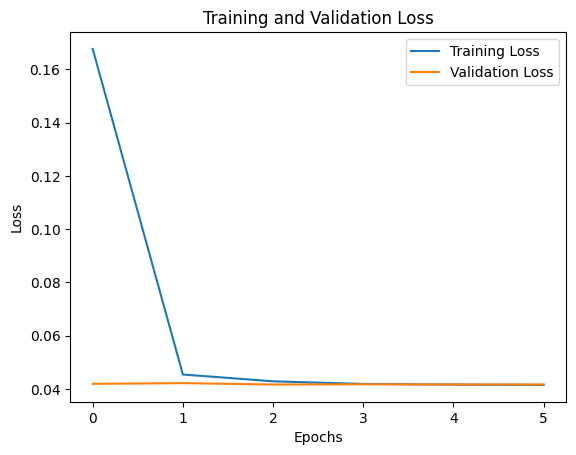

In [125]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generating Recommendations

In [126]:
def generate_recommendations(user_id, model, data, metadata_columns, top_n=10):
    # Get the list of all movie IDs
    all_movie_ids = data['movieId'].unique()

    # Get the list of movie IDs that the user has already rated
    rated_movie_ids = data[data['userId'] == user_id]['movieId'].unique()

    # Get the list of movie IDs that the user hasn't rated yet
    unrated_movie_ids = np.setdiff1d(all_movie_ids, rated_movie_ids)

    # Prepare the metadata for the unrated movies
    # Drop duplicates to ensure one row per movie
    unrated_movie_metadata = (
        data[data['movieId'].isin(unrated_movie_ids)]
        .drop_duplicates(subset=['movieId'])[metadata_columns]
        .values
    )

    # Prepare the input data for the model
    user_ids = np.array([user_id] * len(unrated_movie_ids))
    movie_ids = unrated_movie_ids

    # Predict the ratings
    predicted_ratings = model.predict([user_ids, movie_ids, unrated_movie_metadata])

    # Combine the movie IDs with their predicted ratings
    movie_ratings = list(zip(unrated_movie_ids, predicted_ratings.flatten()))

    # Sort the movies by predicted rating in descending order
    sorted_movie_ratings = sorted(movie_ratings, key=lambda x: x[1], reverse=True)

    # Get the top-N recommendations
    top_n_recommendations = sorted_movie_ratings[:top_n]

    # Print the top-N recommendations
    print(f"Top-{top_n} Recommendations for User {user_id}:")
    for movie_id, rating in top_n_recommendations:
        movie_title = data[data['movieId'] == movie_id]['original_title'].values[0]
        print(f"Movie: {movie_title}, Predicted Rating: {rating:.4f}")

# Example usage
user_id = 0 # User_id as needed
generate_recommendations(user_id, model, movieData, metadata_columns, top_n=10)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Top-10 Recommendations for User 0:
Movie: Boogie Nights, Predicted Rating: 0.7126
Movie: Sweet Sixteen, Predicted Rating: 0.7047
Movie: And Then There Were None, Predicted Rating: 0.7017
Movie: Wag the Dog, Predicted Rating: 0.7010
Movie: A Bridge Too Far, Predicted Rating: 0.6981
Movie: Sister Act, Predicted Rating: 0.6969
Movie: Jack & Sarah, Predicted Rating: 0.6962
Movie: Cat on a Hot Tin Roof, Predicted Rating: 0.6956
Movie: 88 Minutes, Predicted Rating: 0.6949
Movie: Ghost Dog: The Way of the Samurai, Predicted Rating: 0.6948


In [127]:
# Extract test data
test_users = test_data['userId'].values
test_movies = test_data['movieId'].values
test_metadata = test_data[metadata_columns].values
test_ratings = test_data['rating'].values

# Prepare the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(((test_users, test_movies, test_metadata), test_ratings))
test_dataset = test_dataset.batch(64)

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, roc_auc_score, ndcg_score
import numpy as np

def binarize_predictions(predicted_ratings, user_mean_rating):
    """
    Binarize predicted ratings using a threshold (e.g., user's mean rating).
    """
    return (predicted_ratings > user_mean_rating).astype(int)

def compute_metrics(y_true, y_pred, user_mean_rating):
    """
    Compute RMSE, MAE, Precision, Recall, ROC-AUC, and NDCG.
    """
    # Regression metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # Binarize predictions for classification metrics
    y_pred_binary = binarize_predictions(y_pred, user_mean_rating)
    y_true_binary = binarize_predictions(y_true, user_mean_rating)

    # Classification metrics
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true_binary, y_pred)

    # Ranking metric (NDCG)
    ndcg = ndcg_score([y_true], [y_pred], k=10)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'NDCG': ndcg,
    }

def evaluate_model(model, test_dataset, user_mean_rating):
    """
    Evaluate the model on the test dataset.
    """
    # Extract true ratings and predicted ratings
    y_true = []
    y_pred = []

    for (user_ids, movie_ids, metadata), ratings in test_dataset:
        # Predict ratings
        predictions = model.predict([user_ids, movie_ids, metadata])
        y_true.extend(ratings.numpy())
        y_pred.extend(predictions.flatten())

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute metrics
    metrics = compute_metrics(y_true, y_pred, user_mean_rating)
    return metrics

# Compute the mean rating for the test users (used for binarization)
user_mean_rating = np.mean(test_data['rating'].values)

# Evaluate the hybrid NCF model
ncf_metrics = evaluate_model(model, test_dataset, user_mean_rating)

# Print the metrics
print("Hybrid NCF Model Metrics:")
for metric, value in ncf_metrics.items():
    print(f"{metric}: {value:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━

## **All Model Comparison**

In [129]:
bpr_metrics

{'Precision': 0.9124031,
 'Precision with Feature': 0.90193796,
 'Recall': 0.07237290848393318,
 'Recall with Feature': 0.07152653871447982,
 'NDCG': 0.9439713746389767,
 'NDCG with Feature': 0.8958360294550611,
 'MAE': 0.6122528910636902,
 'MAE with Feature': 0.6339375972747803,
 'RMSE': 0.6090341210365295,
 'RMSE with Feature': 0.6310617923736572}

In [130]:
metrics_lr

{'Precision': 0.6863988724453841,
 'Recall': 0.8137009189640768,
 'ROC-AUC': 0.6297645317111791,
 'RMSE': 0.46256262078506394,
 'MAE': 0.41203783393765264,
 'NDCG': 0.75}

In [131]:
metrics_lr_pca

{'Precision': 0.6712707182320442,
 'Recall': 0.8120300751879699,
 'ROC-AUC': 0.6096264946300994,
 'RMSE': 0.465937887733538,
 'MAE': 0.42555616284162834,
 'NDCG': 0.75}

In [132]:
ncf_metrics

{'RMSE': 0.20320345229380274,
 'MAE': 0.16457703522086142,
 'Precision': 0.5828343313373253,
 'Recall': 0.030518394648829432,
 'ROC-AUC': 0.5556291172838398,
 'NDCG': 0.759722222222222}

Precision Comparison

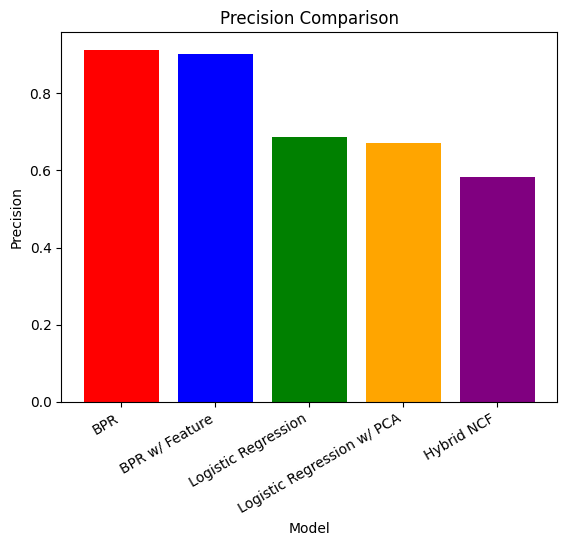

In [133]:
final_precision_eval = {
    'BPR': bpr_metrics['Precision'],
    'BPR w/ Feature': bpr_metrics['Precision with Feature'],
    'Logistic Regression': metrics_lr['Precision'],
    'Logistic Regression w/ PCA': metrics_lr_pca['Precision'],
    'Hybrid NCF': ncf_metrics['Precision']
}

plt.bar(final_precision_eval.keys(), final_precision_eval.values(), color=['red', 'blue', 'green', 'orange', 'purple'])
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Precision Comparison')
plt.xticks(rotation=30, ha="right")
plt.show()

Recall Comparision

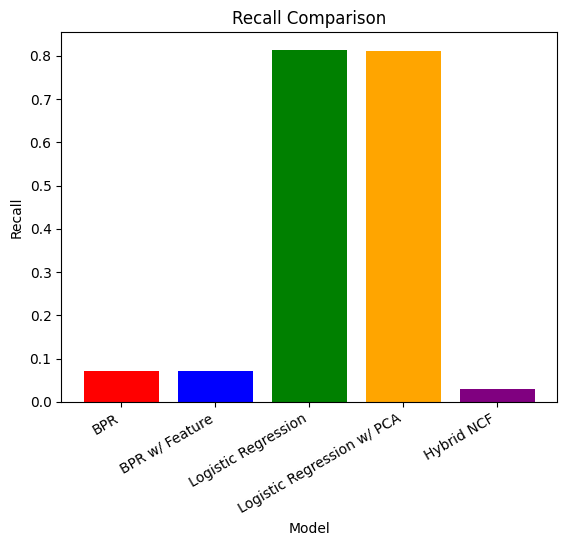

In [134]:
final_recall_eval = {
    'BPR': bpr_metrics['Recall'],
    'BPR w/ Feature': bpr_metrics['Recall with Feature'],
    'Logistic Regression': metrics_lr['Recall'],
    'Logistic Regression w/ PCA': metrics_lr_pca['Recall'],
    'Hybrid NCF': ncf_metrics['Recall']
}

plt.bar(final_recall_eval.keys(), final_recall_eval.values(), color=['red', 'blue', 'green', 'orange', 'purple'])
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Recall Comparison')
plt.xticks(rotation=30, ha="right")
plt.show()

MAE Comparison

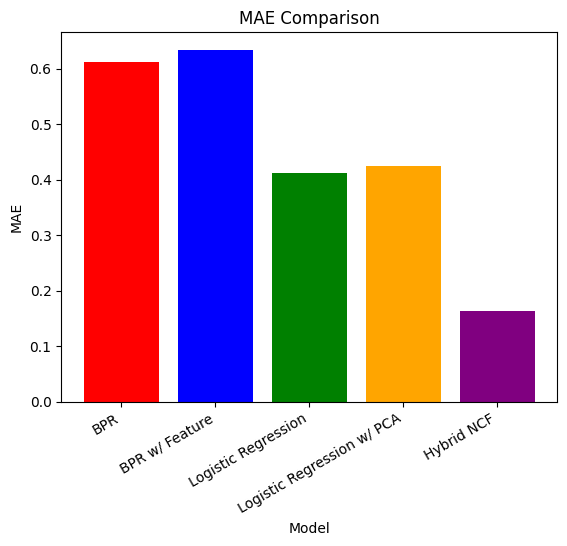

In [135]:
final_mae_eval = {
    'BPR': bpr_metrics['MAE'],
    'BPR w/ Feature': bpr_metrics['MAE with Feature'],
    'Logistic Regression': metrics_lr['MAE'],
    'Logistic Regression w/ PCA': metrics_lr_pca['MAE'],
    'Hybrid NCF': ncf_metrics['MAE']
}

plt.bar(final_mae_eval.keys(), final_mae_eval.values(), color=['red', 'blue', 'green', 'orange', 'purple'])
plt.xlabel('Model')
plt.ylabel('MAE')
plt.title('MAE Comparison')
plt.xticks(rotation=30, ha="right")
plt.show()

RMSE Comparison

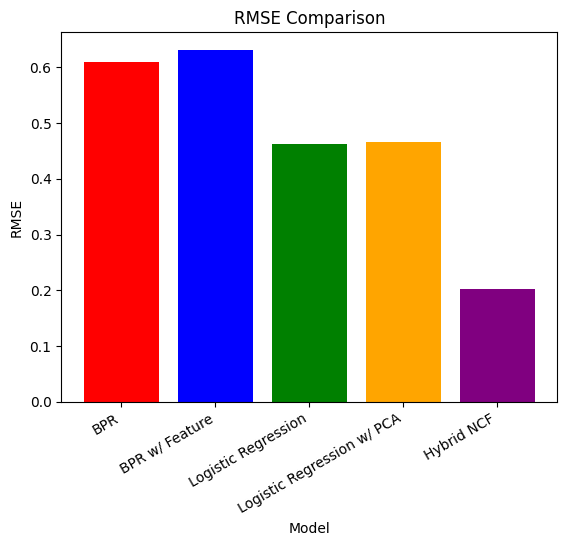

In [136]:
final_rmse_eval = {
    'BPR': bpr_metrics['RMSE'],
    'BPR w/ Feature': bpr_metrics['RMSE with Feature'],
    'Logistic Regression': metrics_lr['RMSE'],
    'Logistic Regression w/ PCA': metrics_lr_pca['RMSE'],
    'Hybrid NCF': ncf_metrics['RMSE']
}

plt.bar(final_rmse_eval.keys(), final_rmse_eval.values(), color=['red', 'blue', 'green', 'orange', 'purple'])
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.xticks(rotation=30, ha="right")
plt.show()

NDCG Comparison

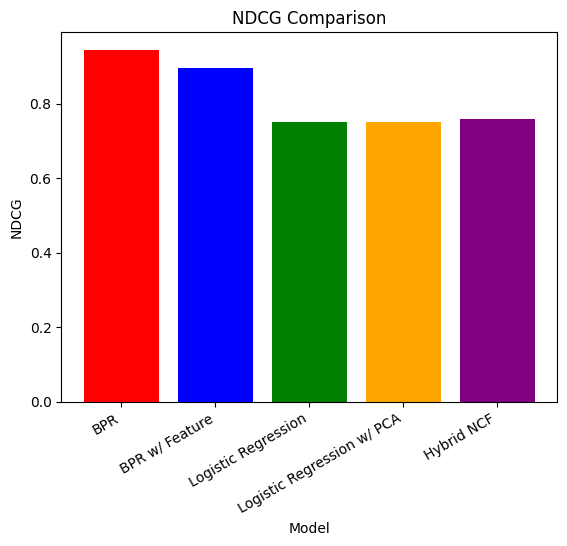

In [137]:
final_ndcg_eval = {
    'BPR': bpr_metrics['NDCG'],
    'BPR w/ Feature': bpr_metrics['NDCG with Feature'],
    'Logistic Regression': metrics_lr['NDCG'],
    'Logistic Regression w/ PCA': metrics_lr_pca['NDCG'],
    'Hybrid NCF': ncf_metrics['NDCG']
}

plt.bar(final_ndcg_eval.keys(), final_ndcg_eval.values(), color=['red', 'blue', 'green', 'orange', 'purple'])
plt.xlabel('Model')
plt.ylabel('NDCG')
plt.title('NDCG Comparison')
plt.xticks(rotation=30, ha="right")
plt.show()